In [71]:
%load_ext autoreload
%autoreload 2

%load_ext scalene

from Optimizer import *
from SlippageModel import average_slippage_model_vectorized, average_slippage_model_cvxpy

import pandas as pd
import numpy as np

import sys
import os
import warnings
from pathlib import Path

import optuna

from fpdf import FPDF

# Absolute or relative path to your library
lib_path = os.path.abspath("/home/ubuntu/git/Baus-Research/")

# Add to sys.path
if lib_path not in sys.path:
    sys.path.append(lib_path)

from src.baus_utils.data_utils import get_tardis_files
from src.baus_utils.system_utils import log_message

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The scalene extension is already loaded. To reload it, use:
  %reload_ext scalene


In [2]:
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [63]:
# In-Samples
#"2022-02-01"-"2022-06-01"
#"2022-11-01"-"2023-05-01"
#"2024-01-01"-"2024-06-01"

start_date = pd.Timestamp("2023-01-01")
end_date = pd.Timestamp("2023-06-15")

In [3]:
def load_data(start_date, end_date):
    print("Loading Data")
    
    # Loading Predicted 
    predicted_returns = pd.read_parquet("forecasts_v4.parquet").set_index("timestamp")
    predicted_returns = predicted_returns.loc[start_date:end_date]

    unique_coins = predicted_returns.TICKER.unique()

    predicted_returns = predicted_returns.iloc[len(unique_coins):].fillna(0)
    predicted_returns = predicted_returns.groupby(level=0, group_keys=False).apply(lambda g: g.sort_values("TICKER"))

    # Loading Residual Returns
    resid_returns = pd.read_parquet("resid_returns_top50.parquet.gz").set_index("timestamp")
    resid_returns = resid_returns.loc[start_date:end_date]
    resid_returns = resid_returns.groupby(level=0, group_keys=False).apply(lambda g: g.sort_values("TICKER")).fillna(0)

    # Loading Factors
    factors = pd.read_parquet("risk_factor_loadings.parquet.gz").set_index("timestamp")
    factors = factors.loc[start_date:end_date].fillna(0)

    exposure_columns = [column_name for column_name in factors.columns if "exposure" in column_name]
    return_columns = [column_name for column_name in factors.columns if "returns" in column_name]

    factor_exposures = factors[exposure_columns + ["TICKER"]].fillna(0)
    factor_returns = factors[return_columns]
    factor_returns = factor_returns.groupby(factor_returns.index).tail(1).fillna(0)

    factor_exposures = factor_exposures.groupby(level=0, group_keys=False).apply(lambda g: g.sort_values("TICKER"))

    # Loading Betas
    betas = pd.read_parquet("factors_top50.parquet.gz").set_index("timestamp")[["beta_clip", "TICKER"]].fillna(0)
    betas = betas.groupby(level=0, group_keys=False).apply(lambda g: g.sort_values("TICKER"))
    betas = betas.loc[start_date:end_date]

    # Loading Volumes
    volumes = pd.DataFrame()
    for coin in unique_coins:
        temp_data = get_tardis_files(start_date, end_date, 'trades', 'time-bars_1h', "binance-futures", f"{coin}USDT",
                                    normalize=True, allow_missing_dates=True, verbose=False, chunksize=10000)
        volumes[coin] = temp_data["dollar_volume"].rolling(24).sum()

    volumes = volumes.reset_index().melt(id_vars="timestamp", var_name="TICKER", value_name="volume").set_index("timestamp")
    volumes = volumes.fillna(0)

    # Loading Funding Rates
    funding_rates = pd.DataFrame()
    for coin in unique_coins:
        funding = get_tardis_files(start_date, end_date, 'derivative_ticker', 'time-bars_1h', "binance-futures", f"{coin}USDT",
                                normalize=True, allow_missing_dates=True, verbose=False)
        funding.loc[funding.index != funding["funding_timestamp"], "funding_rate"] = 0
        funding = funding["funding_rate"]
        funding_rates[coin] = funding
    funding_rates = funding_rates.fillna(0)
    funding_rates = funding_rates.reset_index().melt(id_vars="timestamp", var_name="TICKER", value_name="funding_rate").set_index("timestamp")

    # Loading Liquidity Data
    liquidity = pd.read_csv("LiquidityDataCombined.csv")[["date", "TICKER", "spread", "ask_price", "bid_price"]]
    liquidity["midprice"] = 0.5 * (liquidity["bid_price"] + liquidity["ask_price"])
    liquidity = liquidity.rename(columns={"date":"timestamp"})
    liquidity = liquidity.set_index("timestamp")
    liquidity.index = pd.to_datetime(liquidity.index)
    liquidity = liquidity.loc[start_date:end_date]

    return predicted_returns, resid_returns, factor_returns, factor_exposures, betas, volumes, funding_rates, liquidity, unique_coins

In [4]:
def get_model_error(recovery_rate, liquidity, predicted_returns):
    mean_error_df = liquidity[["midprice", "TICKER"]].copy()
    mean_error_df["return"] = mean_error_df.groupby('TICKER')['midprice'].shift(-1) / liquidity["midprice"] - 1
    mean_error_df = mean_error_df[["TICKER", "return"]]

    mean_error_df = mean_error_df.merge(predicted_returns[["TICKER", "alpha_spec_ret_0_1"]], on=['timestamp', 'TICKER'], how='left').dropna()
    mean_error_df['abs_error'] = np.where(np.sign(mean_error_df['return']) != np.sign(mean_error_df['alpha_spec_ret_0_1']), 
                                                np.abs(mean_error_df['return'] - mean_error_df['alpha_spec_ret_0_1']),
                                                np.sqrt(np.abs(mean_error_df['return'] - mean_error_df['alpha_spec_ret_0_1']))) 

    absolute_mean_error = mean_error_df.groupby(mean_error_df.index.floor('h'))['abs_error'].mean().ewm(span=3*24).mean()
    recent_peak = absolute_mean_error.rolling(window=24, min_periods=1).max()
    recovery_amt = (recent_peak - absolute_mean_error).clip(lower=0)

    new_error = (absolute_mean_error-recovery_rate*recovery_amt).clip(lower=0)
    new_error.name = "error"

    return new_error

In [64]:
predicted_returns, resid_returns, factor_returns, factor_exposures, betas, volumes, funding_rates, liquidity, unique_coins = load_data(start_date, end_date)

Loading Data


In [65]:
new_error = get_model_error(0.5, liquidity, predicted_returns)

In [66]:
max_holding = 0.1         
volume_max_turnover = 0.01/24
min_yearly_return = 0.3
taker_fees = 0.00035 

lambda_0 = 5.703377699222638
alpha = 6239.537064589888
min_portfolio_change = 0.23535660473711714

optimizer = PortfolioOptimizer(unique_coins, max_holding, volume_max_turnover, lambda_0, alpha, min_portfolio_change, min_yearly_return, taker_fees, 5, 24)
target_df = optimizer.generate_target_positions(1000000, predicted_returns, betas, volumes, funding_rates, resid_returns, factor_returns, factor_exposures, new_error, liquidity)

In [34]:
def backtest(AUM, target_df, ba_df, taker_fee, funding_df):
    target_df = target_df.copy()
    ba_df = ba_df.copy()
    funding_df = funding_df.copy()

    target_df['timestamp'] = pd.to_datetime(target_df['timestamp'])
    ba_df['timestamp'] = pd.to_datetime(ba_df['timestamp'])
    funding_df['timestamp'] = pd.to_datetime(funding_df['timestamp'])

    # Pivot targets to matrix: index=datetime, columns=ticker
    W = (target_df
         .pivot_table(index='timestamp', columns='TICKER', values='target', aggfunc='last')
         .sort_index()
         .fillna(0.0))
    
    # Quotes matrices
    bids = (ba_df.pivot_table(index='timestamp', columns='TICKER', values='bid_price', aggfunc='last')
                 .reindex(W.index).sort_index())
    asks = (ba_df.pivot_table(index='timestamp', columns='TICKER', values='ask_price', aggfunc='last')
                 .reindex(W.index).sort_index())
    
    mids = (bids + asks) / 2.0

    # Funding rates matrix
    funding_rates = funding_df.pivot_table(index='timestamp', columns='TICKER', values='funding_rate', aggfunc='last')

    # Align tickers and ffill quotes
    tickers = sorted(set(W.columns) & set(bids.columns) & set(asks.columns))

    W = W.reindex(columns=tickers).fillna(0.0)

    bids = bids.reindex(columns=tickers).ffill()
    asks = asks.reindex(columns=tickers).ffill()
    mids = mids.reindex(columns=tickers).ffill()
    funding_rates = funding_rates.reindex(columns=tickers).ffill()

    # State
    qty = pd.Series(0.0, index=tickers)
    cash = float(AUM)
    fees_cum = 0.0
    funding_pnl_cum = 0.0  # Cumulative funding PnL

    # Storage
    equity_rows, trades_rows, pos_rows = [], [], []
    for t in W.index:
        w = W.loc[t].fillna(0.0)
        bid = bids.loc[t]
        ask = asks.loc[t]
        mid = mids.loc[t]
        funding_rate = funding_rates.loc[t]  # Get funding rates at this time
        
        # Target quantities from constant AUM and mid price
        desired_dollars = AUM * w
        desired_qty = (desired_dollars / mid.replace(0, np.nan)).fillna(0.0)

        # Trade to target
        delta_qty = desired_qty - qty
        buy_mask = delta_qty > 0
        sell_mask = delta_qty < 0
        buy_qty = delta_qty.where(buy_mask, 0.0)
        sell_qty = (-delta_qty).where(sell_mask, 0.0)
        buy_notional = (buy_qty * ask).sum()
        sell_notional = (sell_qty * bid).sum()
        fees = taker_fee * (buy_notional + sell_notional)

        # Update cash and positions
        cash = cash - buy_notional + sell_notional - fees
        qty = qty + delta_qty
        fees_cum -= fees

        # Funding rate effect on cash based on position size (positive or negative depending on long/short)
        funding_cost = (desired_dollars * funding_rate).sum()  # Funding impact based on positions
        cash -= funding_cost  # Deduct funding from cash (if long) or add (if short)
        
        # Cumulative funding PnL
        funding_pnl_cum -= funding_cost

        # Mark-to-market at mid
        port_value = cash + (qty * mid).sum()

        # Reporting
        turnover_notional = (abs(delta_qty) * mid).sum()
        equity_rows.append({
            'datetime': t,
            'portfolio_value': port_value,
            'fees_cum': fees_cum,
            'turnover_notional': turnover_notional,
            'funding_pnl_cum': funding_pnl_cum  # Add cumulative funding PnL
        })

        # Trades log
        if buy_qty.sum() > 0:
            for k in tickers:
                q = float(buy_qty[k])
                if q > 0:
                    fp = float(ask[k])
                    fn = q * fp
                    trades_rows.append({
                        'datetime': t, 'ticker': k, 'trade_qty': q,
                        'fill_price': fp, 'fill_notional': fn, 'fee': taker_fee * fn
                    })

        if sell_qty.sum() > 0:
            for k in tickers:
                q = float(sell_qty[k])
                if q > 0:
                    fp = float(bid[k])
                    fn = q * fp
                    trades_rows.append({
                        'datetime': t, 'ticker': k, 'trade_qty': -q,
                        'fill_price': fp, 'fill_notional': fn, 'fee': taker_fee * fn
                    })

        # Positions snapshot
        snap = qty.copy()
        snap.name = t
        pos_rows.append(snap)

    equity = pd.DataFrame(equity_rows).set_index('datetime').sort_index()
    trades = pd.DataFrame(trades_rows)
    positions = pd.DataFrame(pos_rows)
    positions.index.name = 'datetime'
    positions.columns.name = 'ticker'

    # Convenience columns
    equity['pnl'] = equity['portfolio_value'].diff().fillna(0.0)
    equity['ret'] = equity['portfolio_value'].pct_change().fillna(0.0)
    
    return equity, trades, positions

In [6]:
def get_metrics(equity):
    rets_bps = 10000.0 * pd.Series(equity["portfolio_value"][::24], index=equity.index[::24]).pct_change()
    stats, daily_rets_bps, return_index, drawdown_bps, rolling_1yr_vol_bps = compounded_daily_return_stats(rets_bps)    

    return stats['sharpe                    '], stats['annual_ret/max_drawdown   ']

In [67]:
equity, trades, positions = backtest(1000000, target_df, liquidity.reset_index(), taker_fees, funding_rates.reset_index())

In [72]:
def plot_results(equity):
    figs, axis = plt.subplots(2, figsize=(12, 9))

    axis[0].plot(equity["portfolio_value"] - equity["portfolio_value"].iloc[0], label="PnL After Fees")
    axis[0].plot(equity["portfolio_value"] - equity["fees_cum"] - equity["portfolio_value"].iloc[0], label="Pnl Before Fees")
    axis[0].plot(equity["fees_cum"], label="Total Fees Paid")
    axis[0].plot(equity["funding_pnl_cum"], label="Total Funding PnL")
    axis[0].legend()
    axis[0].grid()

    axis[1].plot(equity["turnover_notional"], label="Turnover Notional")
    axis[1].legend()
    axis[1].grid()

    return figs, axis

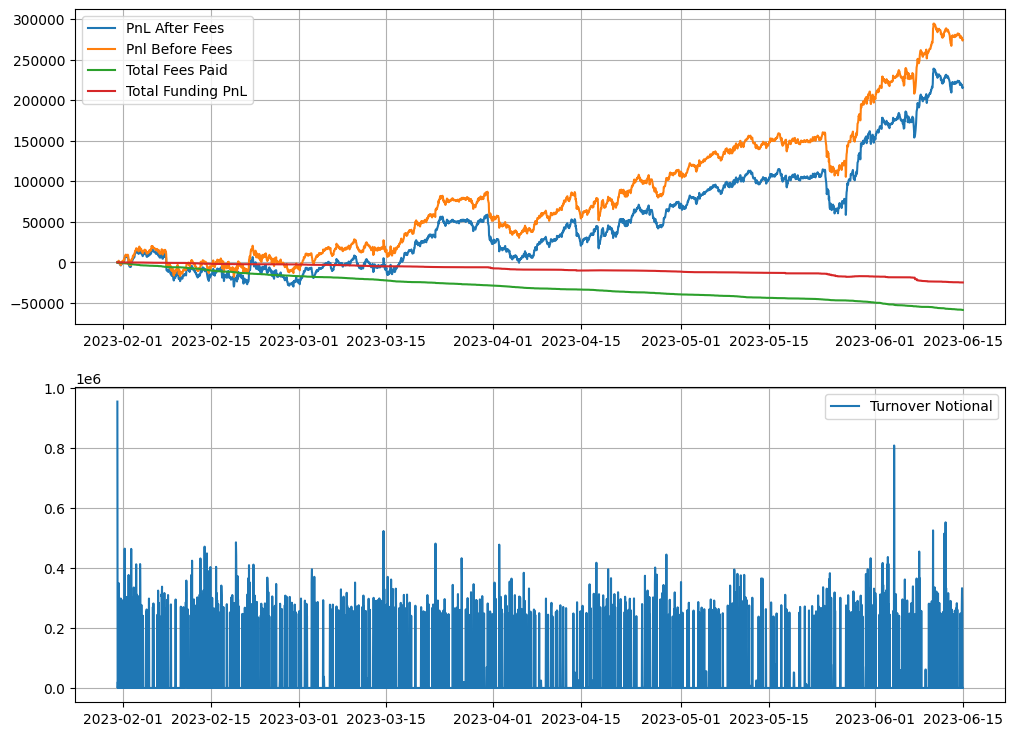

(np.float64(3.0576118861446617), np.float64(14.225735095497711))


In [ ]:
figs, axis = plot_results(equity)
plt.show()
print(get_metrics(equity))

In [9]:
max_holding = 0.1         
volume_max_turnover = 0.01
min_yearly_return = 0.4
taker_fees = 0.00035 

# Bayesian Hyperparameter tuning
def objective(trial):
    recovery_rate = trial.suggest_float('recovery_rate', 0, 2)
    lambda_0 = trial.suggest_float('lambda_0', 0, 50)
    alpha = trial.suggest_float('alpha', 0, 10000)
    min_portfolio_change = trial.suggest_float('min_portfolio_change', 0, 0.4)

    new_error = get_model_error(recovery_rate, liquidity, predicted_returns)

    optimizer = PortfolioOptimizer(unique_coins, max_holding, volume_max_turnover, lambda_0, alpha, min_portfolio_change, min_yearly_return, taker_fees, 5, 24)
    target_df = optimizer.generate_target_positions(1000000, predicted_returns, betas, volumes, funding_rates, resid_returns, factor_returns, factor_exposures, new_error, liquidity)

    equity, trades, positions = backtest(1000000, target_df, liquidity.reset_index(), taker_fees, funding_rates.reset_index())

    sharpe, calmar = get_metrics(equity)

    return 0.4 * sharpe/3 + 0.6*calmar/6


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=300)

print("Number of finished trials", len(study.trials))
print("Best trial:", study.best_trial.params)
print("Best Score:", study.best_trial.value)

[W 2025-08-11 22:57:24,038] Trial 0 failed with parameters: {'recovery_rate': 0.29249997635863134, 'lambda_0': 21.701706780609374, 'alpha': 4416.270409053114, 'min_portfolio_change': 0.3964199014888403} because of the following error: NameError("name 'liquidity' is not defined").
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.10/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_1355976/1609684366.py", line 13, in objective
    new_error = get_model_error(recovery_rate, liquidity, predicted_returns)
NameError: name 'liquidity' is not defined
[W 2025-08-11 22:57:24,042] Trial 0 failed with value None.


NameError: name 'liquidity' is not defined

In [ ]:
# Walk Forward Testing

max_holding = 0.1                
volume_max_turnover = 0.01/24    
min_yearly_return = 0.3
taker_fees = 0.00035 

n_trials = 100

settings_string = f"{max_holding}_{volume_max_turnover}_{min_yearly_return}_{taker_fees}_{n_trials}"

start_date = pd.Timestamp("2022-02-01")
end_date = pd.Timestamp("2022-06-15")
final_date = pd.Timestamp("2025-01-01")

iteration = 1

pdf = FPDF(unit="mm", format="A4"); pdf.set_auto_page_break(True, 12); pdf.add_page()
pdf.set_font("Courier", size=10)
outdir = Path("plots"); outdir.mkdir(exist_ok=True)

while end_date < final_date:
    print(f"Testing {start_date} to {end_date}")
    pdf.multi_cell(0, 5, f"Testing {start_date} to {end_date}")
    # Loading Data
    predicted_returns, resid_returns, factor_returns, factor_exposures, betas, volumes, funding_rates, liquidity, unique_coins = load_data(start_date, end_date)

    # Out-Of-Sample Backtest
    if iteration > 1:
        print("Out-of-Sample Backtest")
        pdf.multi_cell(0, 5, "Out-of-Sample Backtest")
        new_error = get_model_error(optimal_recovery_rate, liquidity, predicted_returns)

        optimizer = PortfolioOptimizer(unique_coins, max_holding, volume_max_turnover, optimal_lambda_0, optimal_alpha, optimal_min_portfolio_change, min_yearly_return, taker_fees, 5, 24)
        target_df = optimizer.generate_target_positions(1000000, predicted_returns, betas, volumes, funding_rates, resid_returns, factor_returns, factor_exposures, new_error, liquidity)

        equity, trades, positions = backtest(1000000, target_df, liquidity.reset_index(), taker_fees, funding_rates.reset_index())    
        sharpe, calmar = get_metrics(equity) 

        fn = outdir / f"OOS-plot_{iteration}_{settings_string}.png"
        figs, axis = plot_results(equity)
        figs.savefig(fn, dpi=150, bbox_inches="tight")
        pdf.image(fn.as_posix(), w=90) 
        plt.show()

        print(f"Sharpe: {sharpe}")
        print(f"Calmar: {calmar}")
        pdf.multi_cell(0, 5, f"Sharpe: {sharpe}")
        pdf.multi_cell(0, 5, f"Calmar: {calmar}")


    # Bayesian Hyperparameter tuning
    print("Hyperparameter Tuning")
    def objective(trial):
        recovery_rate = trial.suggest_float('recovery_rate', 0, 2)
        lambda_0 = trial.suggest_float('lambda_0', 0, 50)
        alpha = trial.suggest_float('alpha', 0, 10000)
        min_portfolio_change = trial.suggest_float('min_portfolio_change', 0, 0.4)

        new_error = get_model_error(recovery_rate, liquidity, predicted_returns)

        optimizer = PortfolioOptimizer(unique_coins, max_holding, volume_max_turnover, lambda_0, alpha, min_portfolio_change, min_yearly_return, taker_fees, 5, 24)
        target_df = optimizer.generate_target_positions(1000000, predicted_returns, betas, volumes, funding_rates, resid_returns, factor_returns, factor_exposures, new_error, liquidity)

        equity, trades, positions = backtest(1000000, target_df, liquidity.reset_index(), taker_fees, funding_rates.reset_index())    
        sharpe, calmar = get_metrics(equity) 

        return 0.4 * sharpe/3 + 0.6*calmar/6

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    optimal_params = study.best_trial.params
    optimal_recovery_rate = optimal_params["recovery_rate"]
    optimal_lambda_0 = optimal_params["lambda_0"]
    optimal_alpha = optimal_params["alpha"]
    optimal_min_portfolio_change = optimal_params["min_portfolio_change"]

    print(f"Optimal Parameters: {optimal_params}")
    pdf.multi_cell(0, 5, f"Optimal Parameters: {optimal_params}")

    # In-Sample-Backtest
    print("In-Sample Backtest")
    pdf.multi_cell(0, 5, "In-Sample Backtest")
    new_error = get_model_error(optimal_recovery_rate, liquidity, predicted_returns)

    optimizer = PortfolioOptimizer(unique_coins, max_holding, volume_max_turnover, optimal_lambda_0, optimal_alpha, optimal_min_portfolio_change, min_yearly_return, taker_fees, 5, 24)
    target_df = optimizer.generate_target_positions(1000000, predicted_returns, betas, volumes, funding_rates, resid_returns, factor_returns, factor_exposures, new_error, liquidity)

    target_df.to_parquet("TargetPositionsOptimizer.parquet")

    equity, trades, positions = backtest(1000000, target_df, liquidity.reset_index(), taker_fees, funding_rates.reset_index())    
    sharpe, calmar = get_metrics(equity) 

    fn = outdir / f"IS-plot_{iteration}_{settings_string}.png"
    figs, axis = plot_results(equity)
    figs.savefig(fn, dpi=150, bbox_inches="tight")
    pdf.image(fn.as_posix(), w=90) 
    plt.show()

    print(f"Sharpe: {sharpe}")
    print(f"Calmar: {calmar}")
    pdf.multi_cell(0, 5, f"Sharpe: {sharpe}")
    pdf.multi_cell(0, 5, f"Calmar: {calmar}")

    start_date += pd.Timedelta(days=182)
    end_date += pd.Timedelta(days=182)
    iteration += 1

pdf.output(f"Walk-Forward-Report_{settings_string}.pdf")

Testing 2022-02-01 00:00:00 to 2022-06-15 00:00:00
Loading Data
